In [ ]:
from scipy.io import wavfile
import librosa
import librosa.display
import matplotlib.pyplot as plt


In [ ]:
x , sr = librosa.load('./drive/MyDrive/COUGHVID/testcough.webm')
x_prime, sr_prime = librosa.load('./testcough.webm')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
print(type(x))

<class 'numpy.ndarray'>


In [ ]:
print(x)

[0.         0.         0.         ... 0.00081741 0.00060595 0.00042479]


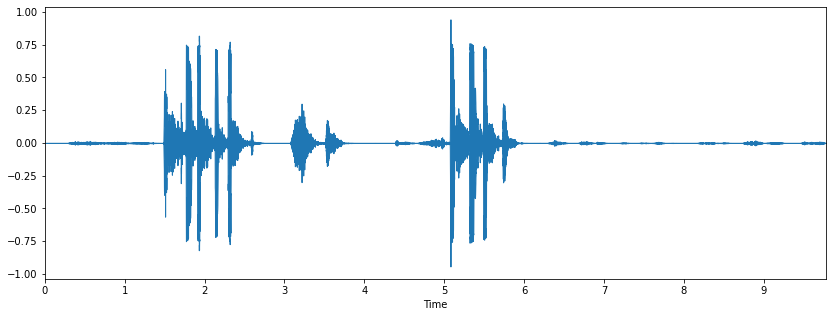

In [ ]:
plt.figure(figsize=(14,5))
librosa.display.waveplot(x)

plt.figure(figsize=(14,5))
lib

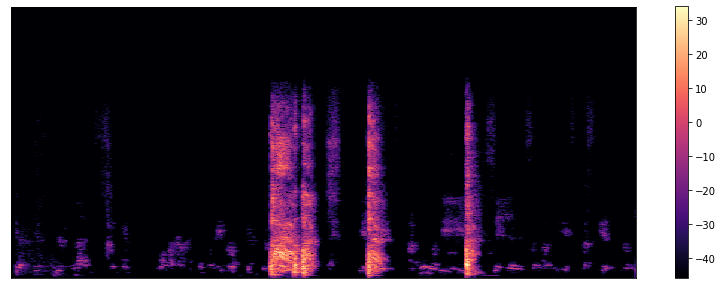

In [ ]:
x_new = librosa.stft(x)
x_db = librosa.amplitude_to_db(abs(x_new))

plt.figure(figsize=(14,5))
librosa.display.specshow(x_db, sr=sr)
plt.colorbar()